In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import time

# 设置数据路径
batch_size = 32
dropout = 0.5
num_epochs = 300
lr = 0.0001
pretrained = 0
optm = "adam"

# 数据路径
data_path = '/hy-tmp/datasets/CUB_200_2011/images'
split_file = '/hy-tmp/datasets/CUB_200_2011/train_test_split.txt'

# 定义数据预处理和增强
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), 
#     transforms.Resize(256),                   
#     transforms.CenterCrop(224), 
#     # transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),        # 随机裁剪并调整到指定大小
#     transforms.RandomHorizontalFlip(),        # 随机水平翻转，增加左右方向上的泛化
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 随机调整亮度、对比度、饱和度和色调
#     transforms.RandomRotation(20),            # 随机旋转±20度
#     transforms.ToTensor(),                    # 转换成Tensor
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化处理
# ])
# val_transforms = transforms.Compose([
#     transforms.Resize(256),                   
#     transforms.CenterCrop(224),               
#     transforms.ToTensor(),                    
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
# ])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 保留更多上下文，裁剪比例为80%到100%
    transforms.RandomHorizontalFlip(p=0.5),               # 50%的概率进行水平翻转
    transforms.RandomVerticalFlip(p=0.2),                 # 20%的概率进行垂直翻转
    transforms.RandomRotation(20),                        # 随机旋转±20度
    transforms.ColorJitter(
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2, 
        hue=0.1
    ),                                                   # 更大幅度调整亮度、对比度、饱和度和色调
    transforms.RandomGrayscale(p=0.1),                    # 10%的概率转换为灰度图像
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1), 
        scale=None, 
        shear=10
    ),                                                   # 随机平移和剪切
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # 随机透视变换
    transforms.ToTensor(),                                # 转换成Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )                                                     # 归一化处理
])

val_transforms = transforms.Compose([
    transforms.Resize(256),                               # 调整大小
    transforms.CenterCrop(224),                           # 中心裁剪
    transforms.ToTensor(),                                # 转换成Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )                                                     # 归一化处理
])


# 加载数据集
full_data = ImageFolder(root=data_path, transform=None)


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset)


# 设置数据集划分比例
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
# test_size = len(full_data) - train_size - val_size

# 划分数据集
# train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])
train_data, val_data = random_split(full_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_data = MyDataset(train_data, train_transforms)
val_data = MyDataset(val_data, val_transforms)
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
# 定义 DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=8)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=8)


# 加载预训练的 ResNet-18 模型
if pretrained:
    model = models.resnet18(weights = "IMAGENET1K_V1", )
else:
    model = models.resnet18(weights = None)


# 修改输出层大小为200
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 200),
    nn.Dropout(dropout),
)

for param in model.parameters():
    param.requires_grad = True
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
if optm == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
elif optm == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.001)
print(model)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# 创建TensorBoard SummaryWriter
suffix_num = timestamp_str = str(int(time.time()))[-6:]
writer = SummaryWriter(log_dir=f'runs5/resnet18_pretrained{pretrained}_lr{lr}_batchsize{batch_size}_epoch{num_epochs}_dropout{dropout}_{optm}_{suffix_num}')

model = model.cuda()

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


训练集大小: 9430
验证集大小: 2358
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

In [4]:
# 训练模型
# best_acc = 0.0
for epoch in range(300, 300 + num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss = train_loss / len(train_loader.batch_sampler)
    train_accuracy = train_correct / train_total
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    
    # 验证模型
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  #不一定是数量完整的batch
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(val_data)
    test_accuracy = test_correct / test_total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)

    # scheduler.step()

    # 保存最好的模型
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        if (pretrained and best_acc > 0.76) or  (not pretrained and best_acc > 0.5):
            torch.save(model.state_dict(), f'saved_models2/resnet18_pretrained{pretrained}_lr{lr}_epoch{num_epochs}_dropout{dropout}_{optm}_acc{best_acc:.6f}.pth')
        
writer.close()

Epoch [301/300], Loss: 2.5355, Accuracy: 0.4757, Test Loss: 1.9266, Accuracy: 0.5411
Epoch [302/300], Loss: 2.4765, Accuracy: 0.4874, Test Loss: 1.9011, Accuracy: 0.5454
Epoch [303/300], Loss: 2.4778, Accuracy: 0.4883, Test Loss: 1.8791, Accuracy: 0.5522
Epoch [304/300], Loss: 2.5208, Accuracy: 0.4780, Test Loss: 1.8640, Accuracy: 0.5577
Epoch [305/300], Loss: 2.4383, Accuracy: 0.4960, Test Loss: 1.8593, Accuracy: 0.5577
Epoch [306/300], Loss: 2.4564, Accuracy: 0.4898, Test Loss: 1.8427, Accuracy: 0.5632
Epoch [307/300], Loss: 2.4472, Accuracy: 0.4915, Test Loss: 1.8344, Accuracy: 0.5636
Epoch [308/300], Loss: 2.4847, Accuracy: 0.4827, Test Loss: 1.8220, Accuracy: 0.5674
Epoch [309/300], Loss: 2.4558, Accuracy: 0.4896, Test Loss: 1.8144, Accuracy: 0.5674
Epoch [310/300], Loss: 2.5059, Accuracy: 0.4781, Test Loss: 1.8037, Accuracy: 0.5700
Epoch [311/300], Loss: 2.4325, Accuracy: 0.4953, Test Loss: 1.8009, Accuracy: 0.5751
Epoch [312/300], Loss: 2.4269, Accuracy: 0.4967, Test Loss: 1.794

In [3]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [4]:
from train_val import train_val
train_val(pretrained=1, lr=0.001, num_epochs=100, dropout=0.1, weight_decay=0.01, log="runs5")

In [7]:
len(train_loader.dataset)

7072

load test

In [18]:
model.load_state_dict(torch.load('saved_models/resnet18_pretrained0_lr0.0001_epoch200_dropout0.5_adam_acc0.618321.pth'))
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  #不一定是数量完整的batch
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_loss = test_loss / len(val_data)
test_accuracy = test_correct / test_total
test_accuracy

0.9113655640373197

# 要在TensorBoard中提取数据并自行绘图

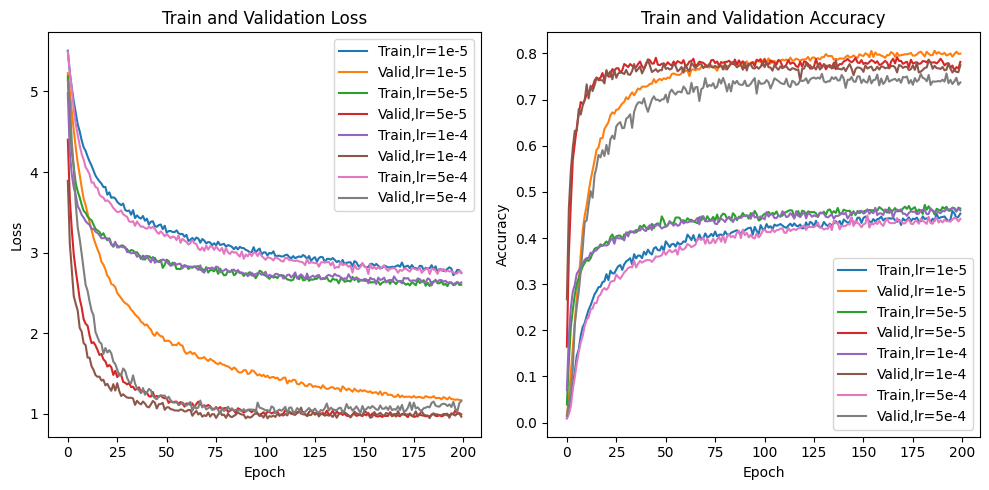

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 定义日志文件路径
log_file_1e_5 = 'runs/resnet18_pretrained1_lr1e-05_epoch200_dropout0.5_adam_lrsch0_525576'
log_file_5e_5 = 'runs/resnet18_pretrained1_lr5e-05_epoch200_dropout0.5_adam_lrsch0_511956'
log_file_1e_4 = 'runs/resnet18_pretrained1_lr0.0001_batchsize32_epoch200_dropout0.5_adam_465038'
log_file_5e_4 = 'runs/resnet18_pretrained1_lr0.0005_epoch200_dropout0.5_adam_lrsch0_531029'


# 初始化 EventAccumulator
event_acc_1e_5 = EventAccumulator(log_file_1e_5).Reload()
event_acc_5e_5 = EventAccumulator(log_file_5e_5).Reload()
event_acc_1e_4 = EventAccumulator(log_file_1e_4).Reload()
event_acc_5e_4 = EventAccumulator(log_file_5e_4).Reload()



# 提取 epoch, loss 和 accuracy 数据
epochs = [x.step for x in event_acc_1e_5.Scalars('Loss/test')]
train_loss_1e_5 = [x.value for x in event_acc_1e_5.Scalars('Loss/train')]
train_accuracy_1e_5 = [x.value for x in event_acc_1e_5.Scalars('Accuracy/train')]
val_loss_1e_5 = [x.value for x in event_acc_1e_5.Scalars('Loss/test')]
val_accuracy_1e_5 = [x.value for x in event_acc_1e_5.Scalars('Accuracy/test')]

train_loss_5e_5 = [x.value for x in event_acc_5e_5.Scalars('Loss/train')]
train_accuracy_5e_5 = [x.value for x in event_acc_5e_5.Scalars('Accuracy/train')]
val_loss_5e_5 = [x.value for x in event_acc_5e_5.Scalars('Loss/test')]
val_accuracy_5e_5 = [x.value for x in event_acc_5e_5.Scalars('Accuracy/test')]

train_loss_1e_4 = [x.value for x in event_acc_1e_4.Scalars('Loss/train')]
train_accuracy_1e_4 = [x.value for x in event_acc_1e_4.Scalars('Accuracy/train')]
val_loss_1e_4 = [x.value for x in event_acc_1e_4.Scalars('Loss/test')]
val_accuracy_1e_4 = [x.value for x in event_acc_1e_4.Scalars('Accuracy/test')]
# val_accuracy_1e_4

train_loss_5e_4 = [x.value for x in event_acc_5e_4.Scalars('Loss/train')]
train_accuracy_5e_4 = [x.value for x in event_acc_5e_4.Scalars('Accuracy/train')]
val_loss_5e_4 = [x.value for x in event_acc_5e_4.Scalars('Loss/test')]
val_accuracy_5e_4 = [x.value for x in event_acc_5e_4.Scalars('Accuracy/test')]

# 创建数据框以便进一步处理
df = pd.DataFrame({'epoch': epochs, 
                   'train_loss_1e_5': train_loss_1e_5, 'train_accuracy_1e_5': train_accuracy_1e_5, 'val_loss_1e_5': val_loss_1e_5, 'val_accuracy_1e_5': val_accuracy_1e_5,
                   'train_loss_5e_5': train_loss_5e_5, 'train_accuracy_5e_5': train_accuracy_5e_5, 'val_loss_5e_5': val_loss_5e_5, 'val_accuracy_5e_5': val_accuracy_5e_5,
                   'train_loss_1e_4': train_loss_1e_4, 'train_accuracy_1e_4': train_accuracy_1e_4, 'val_loss_1e_4': val_loss_1e_4, 'val_accuracy_1e_4': val_accuracy_1e_4,
                   'train_loss_5e_4': train_loss_5e_4, 'train_accuracy_5e_4': train_accuracy_5e_4, 'val_loss_5e_4': val_loss_5e_4, 'val_accuracy_5e_4': val_accuracy_5e_4})

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss_1e_5'], label='Train,lr=1e-5')
plt.plot(df['epoch'], df['val_loss_1e_5'], label='Valid,lr=1e-5')
plt.plot(df['epoch'], df['train_loss_5e_5'], label='Train,lr=5e-5')
plt.plot(df['epoch'], df['val_loss_5e_5'], label='Valid,lr=5e-5')
plt.plot(df['epoch'], df['train_loss_1e_4'], label='Train,lr=1e-4')
plt.plot(df['epoch'], df['val_loss_1e_4'], label='Valid,lr=1e-4')
plt.plot(df['epoch'], df['train_loss_5e_4'], label='Train,lr=5e-4')
plt.plot(df['epoch'], df['val_loss_5e_4'], label='Valid,lr=5e-4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_accuracy_1e_5'], label='Train,lr=1e-5')
plt.plot(df['epoch'], df['val_accuracy_1e_5'], label='Valid,lr=1e-5')
plt.plot(df['epoch'], df['train_accuracy_5e_5'], label='Train,lr=5e-5')
plt.plot(df['epoch'], df['val_accuracy_5e_5'], label='Valid,lr=5e-5')
plt.plot(df['epoch'], df['train_accuracy_1e_4'], label='Train,lr=1e-4')
plt.plot(df['epoch'], df['val_accuracy_1e_4'], label='Valid,lr=1e-4')
plt.plot(df['epoch'], df['train_accuracy_5e_4'], label='Train,lr=5e-4')
plt.plot(df['epoch'], df['val_accuracy_5e_4'], label='Valid,lr=5e-4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.tight_layout()
plt.savefig('vis/loss_acc.png')
plt.show()


In [2]:
import pandas as pd

columns = ['val_accuracy_1e_5', 'val_accuracy_5e_5', 'val_accuracy_1e_4', 'val_accuracy_5e_4']

for col in columns:
    max_val_accuracy = df[col].max()
    max_index = df[col].idxmax()
    corresponding_train_accuracy = df.loc[max_index, col.replace('val', 'train')]
    print(f"Maximum {col}: {max_val_accuracy}")
    print(f"Index of maximum {col}: {max_index}")
    print(f"Corresponding {col.replace('val', 'train')}: {corresponding_train_accuracy}")
    print()


Maximum val_accuracy_1e_5: 0.8057675957679749
Index of maximum val_accuracy_1e_5: 186
Corresponding train_accuracy_1e_5: 0.43718111515045166

Maximum val_accuracy_5e_5: 0.7917726635932922
Index of maximum val_accuracy_5e_5: 167
Corresponding train_accuracy_5e_5: 0.4576955735683441

Maximum val_accuracy_1e_4: 0.7854113578796387
Index of maximum val_accuracy_1e_4: 41
Corresponding train_accuracy_1e_4: 0.4234693944454193

Maximum val_accuracy_5e_4: 0.7565733790397644
Index of maximum val_accuracy_5e_4: 192
Corresponding train_accuracy_5e_4: 0.4366496503353119



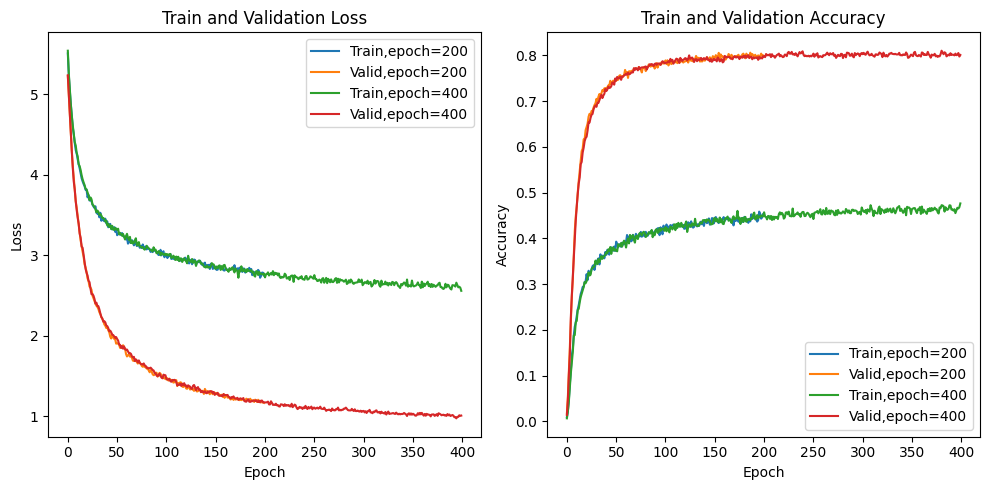

In [3]:
log_file_1e_5_400 = 'runs/resnet18_pretrained1_lr1e-05_epoch400_dropout0.5_adam_lrsch0_540954'
log_file_1e_4_raw = 'runs/resnet18_pretrained0_lr0.0001_batchsize32_epoch500_dropout0.5_adam_450716'
log_file_1e_3_raw_lrsch = 'runs/resnet18_pretrained0_lr0.001_epoch500_dropout0.5_adam_lrsch1_471556'

# 初始化 EventAccumulator
event_acc_1e_5_400 = EventAccumulator(log_file_1e_5_400).Reload()
event_acc_1e_4_raw = EventAccumulator(log_file_1e_4_raw).Reload()
event_acc_1e_3_raw_lrsch = EventAccumulator(log_file_1e_3_raw_lrsch).Reload()

# 提取 epoch, loss 和 accuracy 数据
epochs_1e_5_400 = [x.step for x in event_acc_1e_5_400.Scalars('Loss/test')]
train_loss_1e_5_400 = [x.value for x in event_acc_1e_5_400.Scalars('Loss/train')]
train_accuracy_1e_5_400 = [x.value for x in event_acc_1e_5_400.Scalars('Accuracy/train')]
val_loss_1e_5_400 = [x.value for x in event_acc_1e_5_400.Scalars('Loss/test')]
val_accuracy_1e_5_400 = [x.value for x in event_acc_1e_5_400.Scalars('Accuracy/test')]

epochs_1e_4_raw = [x.step for x in event_acc_1e_4_raw.Scalars('Loss/test')]
train_loss_1e_4_raw = [x.value for x in event_acc_1e_4_raw.Scalars('Loss/train')]
train_accuracy_1e_4_raw = [x.value for x in event_acc_1e_4_raw.Scalars('Accuracy/train')]
val_loss_1e_4_raw = [x.value for x in event_acc_1e_4_raw.Scalars('Loss/test')]
val_accuracy_1e_4_raw = [x.value for x in event_acc_1e_4_raw.Scalars('Accuracy/test')]

epochs_1e_3_raw_lrsch = [x.step for x in event_acc_1e_3_raw_lrsch.Scalars('Loss/test')]
train_loss_1e_3_raw_lrsch = [x.value for x in event_acc_1e_3_raw_lrsch.Scalars('Loss/train')]
train_accuracy_1e_3_raw_lrsch = [x.value for x in event_acc_1e_3_raw_lrsch.Scalars('Accuracy/train')]
val_loss_1e_3_raw_lrsch = [x.value for x in event_acc_1e_3_raw_lrsch.Scalars('Loss/test')]
val_accuracy_1e_3_raw_lrsch = [x.value for x in event_acc_1e_3_raw_lrsch.Scalars('Accuracy/test')]


# 创建数据框以便进一步处理
# df2 = pd.DataFrame({'epoch': epochs_1e_4_raw, 
#                    'train_loss_1e_5_400': train_loss_1e_5_400, 'train_accuracy_1e_5_400': train_accuracy_1e_5_400, 'val_loss_1e_5_400': val_loss_1e_5_400, 'val_accuracy_1e_5_400': val_accuracy_1e_5_400,
#                    'train_loss_1e_4_raw': train_loss_1e_4_raw, 'train_accuracy_1e_4_raw': train_accuracy_1e_4_raw, 'val_loss_1e_4_raw': val_loss_1e_4_raw, 'val_accuracy_1e_4_raw': val_accuracy_1e_4_raw,
#                    'train_loss_1e_3_raw_lrsch': train_loss_1e_3_raw_lrsch, 'train_accuracy_1e_3_raw_lrsch': train_accuracy_1e_3_raw_lrsch, 'val_loss_1e_3_raw_lrsch': val_loss_1e_3_raw_lrsch, 'val_accuracy_1e_3_raw_lrsch': val_accuracy_1e_3_raw_lrsch})



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss_1e_5'], label='Train,epoch=200')
plt.plot(df['epoch'], df['val_loss_1e_5'], label='Valid,epoch=200')
plt.plot(epochs_1e_5_400, train_loss_1e_5_400, label='Train,epoch=400')
plt.plot(epochs_1e_5_400, val_loss_1e_5_400, label='Valid,epoch=400')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_accuracy_1e_5'], label='Train,epoch=200')
plt.plot(df['epoch'], df['val_accuracy_1e_5'], label='Valid,epoch=200')
plt.plot(epochs_1e_5_400, train_accuracy_1e_5_400, label='Train,epoch=400')
plt.plot(epochs_1e_5_400, val_accuracy_1e_5_400, label='Valid,epoch=400')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.tight_layout()
plt.savefig('vis/loss_acc_lr1e-5_epoch.png')
plt.show()
plt.close()

In [7]:
max(val_accuracy_1e_4_raw)

0.6704834699630737

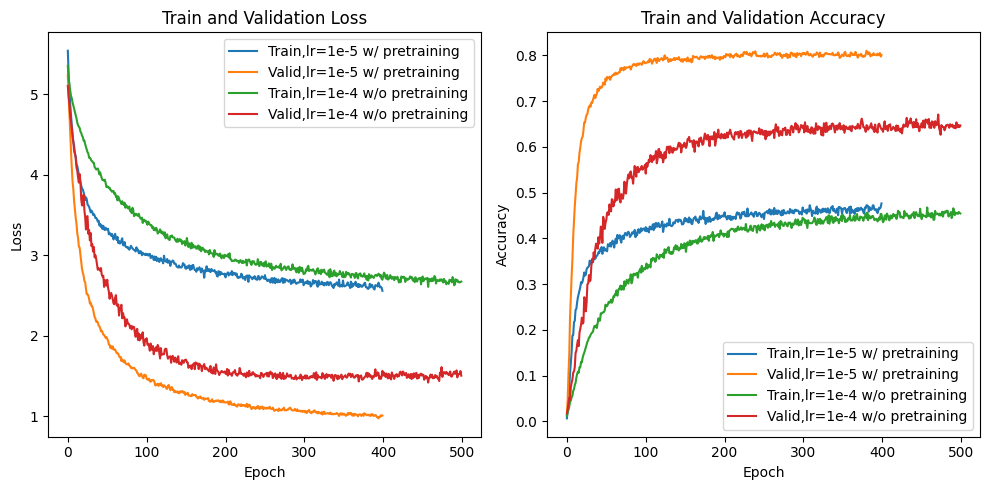

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1e_5_400, train_loss_1e_5_400, label='Train,lr=1e-5 w/ pretraining')
plt.plot(epochs_1e_5_400, val_loss_1e_5_400, label='Valid,lr=1e-5 w/ pretraining')
plt.plot(epochs_1e_4_raw, train_loss_1e_4_raw, label='Train,lr=1e-4 w/o pretraining')
plt.plot(epochs_1e_4_raw, val_loss_1e_4_raw, label='Valid,lr=1e-4 w/o pretraining')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_1e_5_400, train_accuracy_1e_5_400, label='Train,lr=1e-5 w/ pretraining')
plt.plot(epochs_1e_5_400, val_accuracy_1e_5_400, label='Valid,lr=1e-5 w/ pretraining')
plt.plot(epochs_1e_4_raw, train_accuracy_1e_4_raw, label='Train,lr=1e-4 w/o pretraining')
plt.plot(epochs_1e_4_raw, val_accuracy_1e_4_raw, label='Valid,lr=1e-4 w/o pretraining')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.tight_layout()
plt.savefig('vis/loss_acc_pretrained.png')
plt.show()
plt.close()

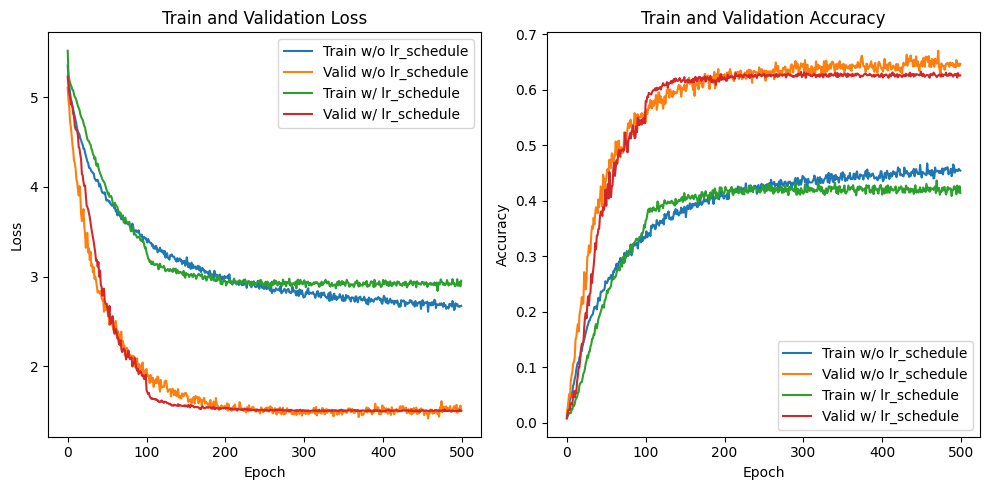

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1e_4_raw, train_loss_1e_4_raw, label='Train w/o lr_schedule')
plt.plot(epochs_1e_4_raw, val_loss_1e_4_raw, label='Valid w/o lr_schedule')
plt.plot(epochs_1e_3_raw_lrsch, train_loss_1e_3_raw_lrsch, label='Train w/ lr_schedule')
plt.plot(epochs_1e_3_raw_lrsch, val_loss_1e_3_raw_lrsch, label='Valid w/ lr_schedule')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_1e_4_raw, train_accuracy_1e_4_raw, label='Train w/o lr_schedule')
plt.plot(epochs_1e_4_raw, val_accuracy_1e_4_raw, label='Valid w/o lr_schedule')
plt.plot(epochs_1e_3_raw_lrsch, train_accuracy_1e_3_raw_lrsch, label='Train w/ lr_schedule')
plt.plot(epochs_1e_3_raw_lrsch, val_accuracy_1e_3_raw_lrsch, label='Valid w/ lr_schedule')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

plt.tight_layout()
plt.savefig('vis/loss_acc_pretrained0_lrsch.png')
plt.show()
plt.close()